# DAC Contest
This reference design will help you walk through a design flow of DAC SDC 2019.

This is a simplified design to help users get started on the FPGA platform and to understand the overall flow. It does not contain any object detection hardware.

If you have any question, please contact [Jeff Goeders at Brigham Young University](mailto:jgoeders@byu.edu).


## Hardware
The base hardware design contains the Zynq MPSoC processor (A53) with a DMA and FIFO implemented in the PL.  
Note that in this starting hardware, no actual image processing is done.
Pictures are:
1. sent from PS to DMA, then DMA to FIFO
2. sent back from FIFO to DMA, then DMA to PS.

Note that the FIFO should be replaced with meaningful hardware to process the pictures.

You can create a Vivado project by opening Vivado 2018.2, changing to an empty directory containing the `dac_contest.tcl` file, and running `source dac_contest.tcl`.  This will create and open a project that you can edit.  Each time you submit your files, you should run `create_bd_tcl teamname.tcl` to generate a new tcl file to submit.

## Software
Note:
1. Any change in `preprocessing.py` will make your design fail in evaluation. This file should not be changed.
2. You can use both PS and PL side to do inference.

Timing for a batch processing should start before "PS reading the first images" and end after "PS receiving all results". 

Please check the reference for details. You can exclude "save_results_xml" when counting time.

Batch size is 500 by default.

Please write your results using the methods `write()` and `save_results_xml()`.

It is your choice how to record the inference result. 
However, it must be readable, and you must convert it to XML files. An example is provided.
Please place your code into `teamname.ipynb`. 
Your design should be able to process all evaluation images in five cells.

### 1. Importing all libraries

In [1]:
import sys
import math
import numpy as np
import os
import time
from PIL import Image
from matplotlib import pyplot
import cv2
from datetime import datetime
import pynq
from pynq import Xlnk
from pynq import Overlay
from preprocessing import Agent
from preprocessing import BATCH_SIZE
from preprocessing import get_image_path

team = 'pynquser'
agent = Agent(team)

Your raw data will be kept in `agent.coord_team`.

Your XML files will be kept in `agent.xml_team`.

Your overlay and weight files will be kept in `agent.overlay_dir_team`.

Your modules and IPYNB file will be kept in `agent.contestant`.

The following cells are not a real design for image detection. But you can
use them to start your design.

### 2. Preparing the overlay and weight loading
Overlay loading must be executed in this cell.

The DMA instance is exposed as an attribute of the overlay object.

Users should populate `<team>` folder. For example, for team `pynquser`, the overlay path shown below
should be `/home/xilinx/jupyter_notebooks/dac_2018/pynquser/overlay/dac_contest.bit`.

The following will just show an example of loading the overlay.

In [2]:
OVERLAY_PATH = '/home/xilinx/jupyter_notebooks/dac_2019_contest/' \
                'overlay/pynquser/dac_contest.bit'
overlay = Overlay(OVERLAY_PATH)
dma = overlay.axi_dma_0

Data flows from PS to PL, then back to PS by DMA. Using an interrupt is recommended.

### 3. Resizing a single picture
The picture pixel data can be read using `opencv` library.

In section 3 and section 4, we will show how to use only the software to resize
an image in the batch and send it from PS to PL.


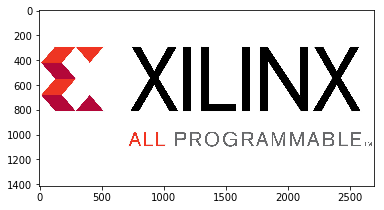

Original image size: 1414x2700 pixels.


In [3]:
interval_time = 0
image_path = get_image_path('1.jpg')

original_image = Image.open(image_path)
original_array = np.array(original_image)
original_image.close()

pyplot.imshow(original_array, interpolation='nearest')
pyplot.show()

old_width, old_height = original_image.size
print("Original image size: {}x{} pixels.".format(old_height, old_width))

Note that this is quite a high-definition picture. 
So you will be resizing this picture to a specific width or height.
The coordinates of the resized picture will be recorded as part of your result.

In the following example, we will resize the image by reducing both the height 
and width by 50%.

Note: This is a software example, so you will notice it is quite slow. In the design
contest, you can explore hardware acceleration for this kind of image processing.

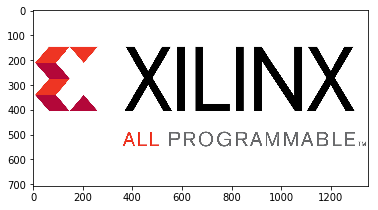

Resized image size: 707x1350 pixels.


In [4]:
new_width, new_height = int(old_width/2), int(old_height/2)
original_image = Image.open(image_path)
resized_image = original_image.resize((new_width, new_height), 
                                      Image.ANTIALIAS)
resized_array = np.array(resized_image)
original_image.close()

pyplot.imshow(resized_array, interpolation='nearest')
pyplot.show()

width, height = resized_image.size
print("Resized image size: {}x{} pixels.".format(height, width))

### 4. Pushing a picture through the pipeline
In the following example, we will also use contiguous memory arrays for sending
and receiving data.

The size of the buffer depends on the size of the input or output data.
Since the image we process in the following example (`pynq.jpg`) has 263x358 RGB pixels,
we will use `cma_array` of the corresponding size as well.

In [5]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(263, 358, 3), dtype=np.uint8, cacheable = 1)
out_buffer = xlnk.cma_array(shape=(263, 358, 3), dtype=np.uint8, cacheable = 1)

Note: In the following example, we are only dealing with one image. 
We will just send one image to the FIFO and loop it back. 
In the real contest, you should process all the RGB images in every batch.

Note that the `rgb_array` has to be copied into the contiguous memory array
(deep copy).

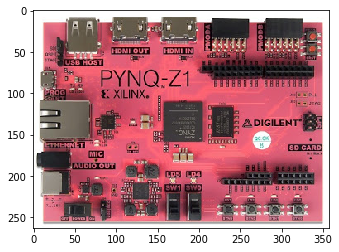

In [6]:
interval_time = 0

image_path = get_image_path('0.jpg')
bgr_array = cv2.imread(image_path)
rgb_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2RGB)
in_buffer[:] = rgb_array

pyplot.imshow(in_buffer)
pyplot.show()

Now we will push the data from input buffer through the pipeline to the output buffer.

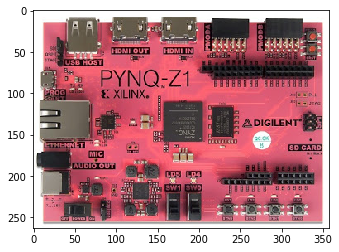

In [7]:
def dma_transfer():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    

dma_transfer()

pyplot.imshow(out_buffer)
pyplot.show()

### 5. Timing and Energy measuring

In this cell, you will:
  * Perform any startup configuraton of your hardware (Download weights, etc.)
  * Run your code for image resizing and processing.
  * Measure the time and energy for processing all the images. 
  
The timer should start before "PS reading the first image" and end after "PS receiving all results".  The code below shows how you can measure the total energy usage.  Make sure you follow this approach.

In the following example we will time the processing and measure energy usage of a single picture.

In [8]:
interval_time = 0
total_time = 0
total_num_img = len(agent.img_list)
result = list()
agent.reset_batch_count()
rails = pynq.get_rails()

for i in range(math.ceil(total_num_img/BATCH_SIZE)):
    # get a batch from agent
    batch = agent.send(interval_time, agent.img_batch)

    # choose a single image from the batch
    first_image = sorted(batch)[0]

    # timer start when PS reading image
    start = time.time()
    
    recorder = pynq.DataRecorder(rails['power1'].power)
    
    with recorder.record(0.01):    
        bgr_array = cv2.imread(get_image_path(first_image))
        rgb_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2RGB)
        in_buffer[:] = rgb_array
    
        dma_transfer()

    # timer stop after PS has received image
    end = time.time()
    t = end - start
    
    energy = recorder.frame["power1_power"].mean() * t
    
    print('Processing time: {} seconds.'.format(t))
    print('Energy: {} J.'.format(energy))
    total_time += t
    result.append(str(out_buffer))

Processing time: 0.012124776840209961 seconds.
Energy: 0.07426425814628601 J.


### 6. Recording results

It is your responsibility to record your results.  You should call `agent.save_results_xml(result_list, total_runtime, total_energy)` to save your results.
  * `results_list`: Each element in this list is a 4-integer list [xmin, xmax, ymin, ymax] indicating the bounding box location deterined by your object detection.  This list should have the same number of elements as there are images.  The first element in the list will correspond to image 0.jpg, etc.
  * `total_runtime`: The total runtime of your processing of all images, as described above.
  * `total_energy`: The total energy of your processing of all images, as described above.
  
The box below shows an example:


In [9]:
result_rectangle =  [[0,358,0,263],[0,1350,0,707]]

agent.save_results_xml(result_rectangle, total_time, energy)
print("XML results written successfully.")

XML results written successfully.


Note: You can use `dac_contest/result/coordinate/teamname/...` to store your any intermediate data and results.

In [10]:
agent.write(total_time, total_num_img, team)

with open(agent.coord_team + '/{}.txt'.format(team), 'w+') as fcoord:
    for element in result:
        fcoord.write(element)
        fcoord.write('\n')
print("Coordinate results written successfully.")

Coordinate results written successfully.


### 7. Cleaning up
Remember to free the contiguous memory after usage.

In [11]:
xlnk.xlnk_reset()

### 8. What to submit
Create your own notebook file (.ipynb), you don't need to modify this one.  **Make sure your notebook contains exactly five cells:**

* Cell one: importing all libraries and initializing only(section 1).

* Cell two: downloading the overlay only (section 2).

* Cell three: Configuring your hardware, resizing and processing of all images (section 3, 4 and 5).

* Cell four: Write results to XML (section 6).

* Cell five: clean up.

In cell 3, the timer should be added by contestants. 
Data transmission between PL and DDR during processing is allowed.
However, you should meet the FPS requirement.

The monthly submission should include bitstream file, tcl file, ipynb file and a README file.

The final submission should include the files mentioned above and all the source code.

A README file is mandatory.

A design block diagram file for your design is mandatory for the last submission.

##  Design Block Diagram
All contestants are welcome to submit your block diagram monthly with your design.

Your designs will be analyzed by Xilinx engineers, and may help in creating better IP for accelerating neural networks on FPGAs. 
